# Lab 05b: Social Network (graph) analytics

Preliminary data exploration on Reddit data using graphical visualizations. 

Note: I skipped over the first sections of lab 05b for a few reasons. First, I used the link to the reddit comment data that was placed on the forum instead of the transmission client described in the notebook because it had issues maintaining connection. I did not want to redo the creation of the table 'rc' because I had already completed this step in the lab, so the table was already saved in my HiveQL reddit_comments_feb23 database. I did however repeatedly use the "ADD JAR /home/cbutl002/Hive-JSON-Serde/json-serde/target/json-serde-1.3.8-SNAPSHOT-jar-with-dependencies.jar;" line to be able to read the reddit comments.  The following is my subsetting and analysis of the data.

In [2]:
import pylab
import igraph
import matplotlib
import pandas
import numpy
import graphistry
graphistry.register(key='a16918d5aaa30201ed0bbba1fc70a7e561b7740ca4713119165dd77011f68f29855fdced90924fa70aa4966625dfafad')
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [9]:
%qtconsole --colors=Linux

In [3]:
G = igraph.Graph.Read_Ncol('rcreply.ncol')

To register with the Python module Graphistry, I had to request a key to the server to create each plot.  However, when I tried to plot this graph using Graphistry as opposed to iGraph, but the graph was so large that it crashed the Graphistry server!

In [4]:
graphistry.bind(source='G.indegree', destination='G.outdegree').plot(G)

Uploading 32028 kB. This may take a while...


Large graph: |nodes| + |edges| = 3983189. Layout/rendering might be slow.


HTTPError: 502 Server Error: Bad Gateway for url: http://labs.graphistry.com/etl?key=a16918d5aaa30201ed0bbba1fc70a7e561b7740ca4713119165dd77011f68f29855fdced90924fa70aa4966625dfafad&usertag=10c6cb5f-pygraphistry-0.9.25&agent=pygraphistry&apiversion=1&agentversion=0.9.25

In [67]:
print("number of vertices:",len(G.vs)," number of edges:", len(G.es))

number of vertices: 805707  number of edges: 3177482


In [68]:
print("max in-degree: %s, max out-degree: %s" % (G.maxdegree(mode='IN'), G.maxdegree(mode='OUT')))

max in-degree: 2204, max out-degree: 828


In [69]:
vmaxin = G.vs.select(_indegree=G.maxdegree(mode='IN'))

In [70]:
vmaxout = G.vs.select(_outdegree=G.maxdegree(mode='OUT'))

In [71]:
print("maximum-degree commenters: %s, %s" % (vmaxin["name"], vmaxout["name"]))

maximum-degree commenters: ['autowikibot'], ['AutoModerator']


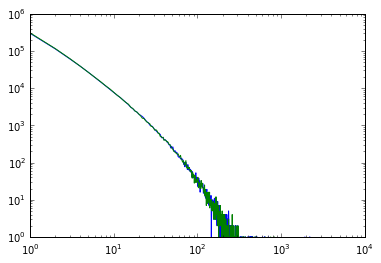

In [72]:
hi = G.degree_distribution(mode='IN')
ho = G.degree_distribution(mode='OUT')
pylab.xscale('log')
pylab.yscale('log')
pylab.plot([x[0] for x in hi.bins()], [x[2] for x in hi.bins()])
pylab.plot([x[0] for x in ho.bins()], [x[2] for x in ho.bins()])

# Lab 06a: Graph analytics of subreddit comments

I will:

-> use subqueries to select subsets of the reddit comments to generate parent-child relationships.

-> alter configuration parameters of the Hive shell and execution engine.

-> use partitions to store a number of subsets of the data for easy later use in external tools.


## 1. Subsetting the data

In [ ]:
hive> insert overwrite local directory '/home/cbutl002/rcbigdata'                   
    > row format delimited fields terminated by '\t'
    > select a.author, b.author, count(*) from
    > (select * from rc where subreddit = 'bigdata') a
    > join
    > (select * from rc where subreddit ='bigdata') b
    > on a.name = b.parent_id
    > group by a.author, b.author;
Query ID = cbutl002_20160328155959_aeb35434-1257-45a9-b0e5-99b1bb5d549a
Total jobs = 2
Stage-1 is selected by condition resolver.
Launching Job 1 out of 2
Number of reduce tasks not specified. Estimated from input data size: 22
In order to change the average load for a reducer (in bytes):
  set hive.exec.reducers.bytes.per.reducer=<number>
In order to limit the maximum number of reducers:
  set hive.exec.reducers.max=<number>
In order to set a constant number of reducers:
  set mapreduce.job.reduces=<number>
Starting Job = job_1457314320880_0033, Tracking URL = http://dsm1:8088/proxy/application_1457314320880_0033/
Kill Command = /usr/local/hadoop/bin/hadoop job  -kill job_1457314320880_0033
Hadoop job information for Stage-1: number of mappers: 41; number of reducers: 22
2016-03-28 15:59:12,941 Stage-1 map = 0%,  reduce = 0%
2016-03-28 15:59:24,503 Stage-1 map = 1%,  reduce = 0%, Cumulative CPU 152.75 sec
2016-03-28 15:59:26,602 Stage-1 map = 2%,  reduce = 0%, Cumulative CPU 314.96 sec
2016-03-28 15:59:28,769 Stage-1 map = 3%,  reduce = 0%, Cumulative CPU 454.76 sec
2016-03-28 15:59:29,831 Stage-1 map = 4%,  reduce = 0%, Cumulative CPU 528.57 sec
2016-03-28 15:59:31,926 Stage-1 map = 5%,  reduce = 0%, Cumulative CPU 628.16 sec
#
# ...
#
2016-03-28 16:01:53,140 Stage-1 map = 100%,  reduce = 32%, Cumulative CPU 6604.72 sec
2016-03-28 16:01:54,166 Stage-1 map = 100%,  reduce = 63%, Cumulative CPU 6615.58 sec
2016-03-28 16:01:55,185 Stage-1 map = 100%,  reduce = 100%, Cumulative CPU 6631.39 sec
MapReduce Total cumulative CPU time: 0 days 1 hours 50 minutes 31 seconds 390 msec
Ended Job = job_1457314320880_0033
Launching Job 2 out of 2
Number of reduce tasks not specified. Estimated from input data size: 1
In order to change the average load for a reducer (in bytes):
  set hive.exec.reducers.bytes.per.reducer=<number>
In order to limit the maximum number of reducers:
  set hive.exec.reducers.max=<number>
In order to set a constant number of reducers:
  set mapreduce.job.reduces=<number>
Starting Job = job_1457314320880_0034, Tracking URL = http://dsm1:8088/proxy/application_1457314320880_0034/
Kill Command = /usr/local/hadoop/bin/hadoop job  -kill job_1457314320880_0034
Hadoop job information for Stage-2: number of mappers: 6; number of reducers: 1
2016-03-28 16:02:01,751 Stage-2 map = 0%,  reduce = 0%
2016-03-28 16:02:05,866 Stage-2 map = 50%,  reduce = 0%, Cumulative CPU 2.45 sec
2016-03-28 16:02:06,892 Stage-2 map = 100%,  reduce = 0%, Cumulative CPU 5.37 sec
2016-03-28 16:02:10,994 Stage-2 map = 100%,  reduce = 100%, Cumulative CPU 6.63 sec
MapReduce Total cumulative CPU time: 6 seconds 630 msec
Ended Job = job_1457314320880_0034
Copying data to local directory /home/cbutl002/rcbigdata
Copying data to local directory /home/cbutl002/rcbigdata
MapReduce Jobs Launched: 
Stage-Stage-1: Map: 41  Reduce: 22   Cumulative CPU: 6631.39 sec   HDFS Read: 5462381833 HDFS Write: 4086 SUCCESS
Stage-Stage-2: Map: 6  Reduce: 1   Cumulative CPU: 6.63 sec   HDFS Read: 10566 HDFS Write: 1152 SUCCESS
Total MapReduce CPU Time Spent: 0 days 1 hours 50 minutes 38 seconds 20 msec
OK
Time taken: 186.668 seconds


**Action:** describe in words what you expect this query to produce, and where. Run it (altering the youid001 to your userid) and see if the output is what you expect. You may need to USE 05b first.

I would expect this to produce a new tab-delimited data table in a folder called rcbig data.  It would be a joined dataset from two tables a and b, which are both the full selection of the a and b tables taken from the bigdata subreddit.  It would count the number of authors who are parent authors of a comment in a subthread.

In reality, this command seems to have made a few datasets which list the username of each user, the threads that they have replied on, and the count of the replies.

**Action:** choose another subreddit, maybe one that is bigger (e.g. leagueoflegends), and rerun the query (alter the destination directory). Does the query take any longer to run?

I chose to run the command on the leagueoflegends subreddit.  The bigdata subreddit MapReduce job took about 3 minutes to run, and the leagueoflegends subreddit MapReduce job took about 3 minutes to run, as well.  The input and output is below:

In [ ]:
hive> insert overwrite local directory '/home/cbutl002/leagueoflegends'             > row format delimited fields terminated by '\t'                                > select a.author, b.author, count(*) from                                      > (select * from rc where subreddit = 'leagueoflegends') a                      > join                                                                          > (select * from rc where subreddit = 'leagueoflegends') b                      > on a.name = b.parent_id                                                       > group by a.author, b.author; 
Query ID = cbutl002_20160328161818_aaf1d655-1b9f-425a-b6c0-86495b4a5543
Total jobs = 2
Stage-1 is selected by condition resolver.
Launching Job 1 out of 2
Number of reduce tasks not specified. Estimated from input data size: 22
In order to change the average load for a reducer (in bytes):
  set hive.exec.reducers.bytes.per.reducer=<number>
In order to limit the maximum number of reducers:
  set hive.exec.reducers.max=<number>
In order to set a constant number of reducers:
  set mapreduce.job.reduces=<number>
Starting Job = job_1457314320880_0035, Tracking URL = http://dsm1:8088/proxy/application_1457314320880_0035/
Kill Command = /usr/local/hadoop/bin/hadoop job  -kill job_1457314320880_0035
Hadoop job information for Stage-1: number of mappers: 41; number of reducers: 22
2016-03-28 16:18:22,893 Stage-1 map = 0%,  reduce = 0%
2016-03-28 16:18:33,518 Stage-1 map = 1%,  reduce = 0%, Cumulative CPU 91.87 sec
2016-03-28 16:18:36,662 Stage-1 map = 2%,  reduce = 0%, Cumulative CPU 329.92 sec
2016-03-28 16:18:37,709 Stage-1 map = 3%,  reduce = 0%, Cumulative CPU 414.59 sec
2016-03-28 16:18:39,809 Stage-1 map = 4%,  reduce = 0%, Cumulative CPU 542.4 sec
2016-03-28 16:18:41,914 Stage-1 map = 5%,  reduce = 0%, Cumulative CPU 649.9 sec
#
# ...
#
2016-03-28 16:21:03,963 Stage-1 map = 97%,  reduce = 31%, Cumulative CPU 6457.47 sec
2016-03-28 16:21:15,181 Stage-1 map = 98%,  reduce = 31%, Cumulative CPU 6506.44 sec
2016-03-28 16:21:17,221 Stage-1 map = 100%,  reduce = 31%, Cumulative CPU 6517.32 sec
2016-03-28 16:21:18,242 Stage-1 map = 100%,  reduce = 48%, Cumulative CPU 6523.4 sec
2016-03-28 16:21:19,266 Stage-1 map = 100%,  reduce = 66%, Cumulative CPU 6550.58 sec
2016-03-28 16:21:20,286 Stage-1 map = 100%,  reduce = 100%, Cumulative CPU 6606.53 sec
MapReduce Total cumulative CPU time: 0 days 1 hours 50 minutes 6 seconds 530 msec
Ended Job = job_1457314320880_0035
Launching Job 2 out of 2
Number of reduce tasks not specified. Estimated from input data size: 1
In order to change the average load for a reducer (in bytes):
  set hive.exec.reducers.bytes.per.reducer=<number>
In order to limit the maximum number of reducers:
  set hive.exec.reducers.max=<number>
In order to set a constant number of reducers:
  set mapreduce.job.reduces=<number>
Starting Job = job_1457314320880_0036, Tracking URL = http://dsm1:8088/proxy/application_1457314320880_0036/
Kill Command = /usr/local/hadoop/bin/hadoop job  -kill job_1457314320880_0036
Hadoop job information for Stage-2: number of mappers: 6; number of reducers: 1
2016-03-28 16:21:27,506 Stage-2 map = 0%,  reduce = 0%
2016-03-28 16:21:32,631 Stage-2 map = 83%,  reduce = 0%, Cumulative CPU 13.05 sec
2016-03-28 16:21:34,675 Stage-2 map = 100%,  reduce = 0%, Cumulative CPU 17.27 sec
2016-03-28 16:21:39,792 Stage-2 map = 100%,  reduce = 100%, Cumulative CPU 21.84 sec
MapReduce Total cumulative CPU time: 21 seconds 840 msec
Ended Job = job_1457314320880_0036
Copying data to local directory /home/cbutl002/leagueoflegends
Copying data to local directory /home/cbutl002/leagueoflegends
MapReduce Jobs Launched: 
Stage-Stage-1: Map: 41  Reduce: 22   Cumulative CPU: 6606.53 sec   HDFS Read: 5462381833 HDFS Write: 20436085 SUCCESS
Stage-Stage-2: Map: 6  Reduce: 1   Cumulative CPU: 21.84 sec   HDFS Read: 20442565 HDFS Write: 10467897 SUCCESS
Total MapReduce CPU Time Spent: 0 days 1 hours 50 minutes 28 seconds 370 msec
OK
Time taken: 205.624 seconds
hive> 

## 2. Muptiple Outputs at Once

**Action:** write and execute a query to find out how many different subreddits are represented in the comment data.

In [ ]:
# the query I wrote
SELECT COUNT(DISTINCT subreddit) AS num_subreddits FROM rc;

This query efficiently counts the number of unique subreddit threads by counting distinct values in the subreddit field from the rc data table and renaming it under the alias num_subreddits. It ran in just about 2 minutes, as shown below:

In [ ]:
# input and output

hive> select count(distinct subreddit) as subreddit_count from rc;              Query ID = cbutl002_20160328165252_89cfbeed-62ec-4922-b71d-f2330523ec3f
Total jobs = 1
Launching Job 1 out of 1
Number of reduce tasks determined at compile time: 1
In order to change the average load for a reducer (in bytes):
  set hive.exec.reducers.bytes.per.reducer=<number>
In order to limit the maximum number of reducers:
  set hive.exec.reducers.max=<number>
In order to set a constant number of reducers:
  set mapreduce.job.reduces=<number>
Starting Job = job_1457314320880_0038, Tracking URL = http://dsm1:8088/proxy/application_1457314320880_0038/
Kill Command = /usr/local/hadoop/bin/hadoop job  -kill job_1457314320880_0038
Hadoop job information for Stage-1: number of mappers: 41; number of reducers: 1
2016-03-28 16:52:53,314 Stage-1 map = 0%,  reduce = 0%
2016-03-28 16:53:03,815 Stage-1 map = 1%,  reduce = 0%, Cumulative CPU 73.83 sec
2016-03-28 16:53:05,928 Stage-1 map = 2%,  reduce = 0%, Cumulative CPU 221.8 sec
2016-03-28 16:53:06,985 Stage-1 map = 3%,  reduce = 0%, Cumulative CPU 305.79 sec
2016-03-28 16:53:08,030 Stage-1 map = 4%,  reduce = 0%, Cumulative CPU 377.36 sec
2016-03-28 16:53:10,136 Stage-1 map = 5%,  reduce = 0%, Cumulative CPU 510.88 sec
2016-03-28 16:53:11,188 Stage-1 map = 6%,  reduce = 0%, Cumulative CPU 559.62 sec
2016-03-28 16:53:12,233 Stage-1 map = 7%,  reduce = 0%, Cumulative CPU 623.67 sec
2016-03-28 16:53:14,373 Stage-1 map = 8%,  reduce = 0%, Cumulative CPU 723.99 sec
# 
# ...
#
2016-03-28 16:54:53,758 Stage-1 map = 91%,  reduce = 23%, Cumulative CPU 5358.48 sec
2016-03-28 16:54:54,779 Stage-1 map = 96%,  reduce = 23%, Cumulative CPU 5377.62 sec
2016-03-28 16:54:55,799 Stage-1 map = 98%,  reduce = 29%, Cumulative CPU 5395.2 sec
2016-03-28 16:54:56,824 Stage-1 map = 100%,  reduce = 29%, Cumulative CPU 5399.89 sec
2016-03-28 16:54:58,864 Stage-1 map = 100%,  reduce = 69%, Cumulative CPU 5401.87 sec
2016-03-28 16:54:59,888 Stage-1 map = 100%,  reduce = 100%, Cumulative CPU 5402.94 sec
MapReduce Total cumulative CPU time: 0 days 1 hours 30 minutes 2 seconds 940 msec
Ended Job = job_1457314320880_0038
MapReduce Jobs Launched: 
Stage-Stage-1: Map: 41  Reduce: 1   Cumulative CPU: 5402.94 sec   HDFS Read: 5462381833 HDFS Write: 6 SUCCESS
Total MapReduce CPU Time Spent: 0 days 1 hours 30 minutes 2 seconds 940 msec
OK
47172


Thus, the total number of unique subreddit threads is 47,172. 

## 3. Multiple outputs at once, take 2

**Action:** ask hive to EXPLAIN these queries. Based on the explanation, would you expect one or the other to be faster? Test your expectation.

In [ ]:
hive> EXPLAIN select c.* from (select subreddit, count(*) as count from rc group by subreddit) c where c.count >10000;
OK
STAGE DEPENDENCIES:
  Stage-1 is a root stage
  Stage-0 depends on stages: Stage-1

STAGE PLANS:
  Stage: Stage-1
    Map Reduce
      Map Operator Tree:
          TableScan
            alias: rc
            Statistics: Num rows: 54524134 Data size: 5452413440 Basic stats: COMPLETE Column stats: NONE
            Select Operator
              expressions: subreddit (type: string)
              outputColumnNames: subreddit
              Statistics: Num rows: 54524134 Data size: 5452413440 Basic stats: COMPLETE Column stats: NONE
              Group By Operator
                aggregations: count()
                keys: subreddit (type: string)
                mode: hash
                outputColumnNames: _col0, _col1
                Statistics: Num rows: 54524134 Data size: 5452413440 Basic stats: COMPLETE Column stats: NONE
                Reduce Output Operator
                  key expressions: _col0 (type: string)
                  sort order: +
                  Map-reduce partition columns: _col0 (type: string)
                  Statistics: Num rows: 54524134 Data size: 5452413440 Basic stats: COMPLETE Column stats: NONE
                  value expressions: _col1 (type: bigint)
      Reduce Operator Tree:
        Group By Operator
          aggregations: count(VALUE._col0)
          keys: KEY._col0 (type: string)
          mode: mergepartial
          outputColumnNames: _col0, _col1
          Statistics: Num rows: 27262067 Data size: 2726206720 Basic stats: COMPLETE Column stats: NONE
          Filter Operator
            predicate: (_col1 > 10000) (type: boolean)
            Statistics: Num rows: 9087355 Data size: 908735506 Basic stats: COMPLETE Column stats: NONE
            Select Operator
              expressions: _col0 (type: string), _col1 (type: bigint)
              outputColumnNames: _col0, _col1
              Statistics: Num rows: 9087355 Data size: 908735506 Basic stats: COMPLETE Column stats: NONE
              File Output Operator
                compressed: false
                Statistics: Num rows: 9087355 Data size: 908735506 Basic stats: COMPLETE Column stats: NONE
                table:
                    input format: org.apache.hadoop.mapred.TextInputFormat
                    output format: org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat
                    serde: org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe

  Stage: Stage-0
    Fetch Operator
      limit: -1
      Processor Tree:
        ListSink

Time taken: 0.117 seconds, Fetched: 55 row(s)

In [ ]:
hive> EXPLAIN select subreddit, count(*) from rc group by subreddit having count(*) > 10000;
OK
STAGE DEPENDENCIES:
  Stage-1 is a root stage
  Stage-0 depends on stages: Stage-1

STAGE PLANS:
  Stage: Stage-1
    Map Reduce
      Map Operator Tree:
          TableScan
            alias: rc
            Statistics: Num rows: 54524134 Data size: 5452413440 Basic stats: COMPLETE Column stats: NONE
            Select Operator
              expressions: subreddit (type: string)
              outputColumnNames: subreddit
              Statistics: Num rows: 54524134 Data size: 5452413440 Basic stats: COMPLETE Column stats: NONE
              Group By Operator
                aggregations: count()
                keys: subreddit (type: string)
                mode: hash
                outputColumnNames: _col0, _col1
                Statistics: Num rows: 54524134 Data size: 5452413440 Basic stats: COMPLETE Column stats: NONE
                Reduce Output Operator
                  key expressions: _col0 (type: string)
                  sort order: +
                  Map-reduce partition columns: _col0 (type: string)
                  Statistics: Num rows: 54524134 Data size: 5452413440 Basic stats: COMPLETE Column stats: NONE
                  value expressions: _col1 (type: bigint)
      Reduce Operator Tree:
        Group By Operator
          aggregations: count(VALUE._col0)
          keys: KEY._col0 (type: string)
          mode: mergepartial
          outputColumnNames: _col0, _col1
          Statistics: Num rows: 27262067 Data size: 2726206720 Basic stats: COMPLETE Column stats: NONE
          Filter Operator
            predicate: (_col1 > 10000) (type: boolean)
            Statistics: Num rows: 9087355 Data size: 908735506 Basic stats: COMPLETE Column stats: NONE
            Select Operator
              expressions: _col0 (type: string), _col1 (type: bigint)
              outputColumnNames: _col0, _col1
              Statistics: Num rows: 9087355 Data size: 908735506 Basic stats: COMPLETE Column stats: NONE
              File Output Operator
                compressed: false
                Statistics: Num rows: 9087355 Data size: 908735506 Basic stats: COMPLETE Column stats: NONE
                table:
                    input format: org.apache.hadoop.mapred.TextInputFormat
                    output format: org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat
                    serde: org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe

  Stage: Stage-0
    Fetch Operator
      limit: -1
      Processor Tree:
        ListSink

Time taken: 0.048 seconds, Fetched: 55 row(s)


From what I can tell, it looks as though these two commands will run the two commands using more or less the same approaches.  If I had to choose which one I thought would run more efficiently, I would choose the second one because it has a more condensed command line.  I run them both below:

In [ ]:
hive> select c.* from (select subreddit, count(*) as count from rc group by subreddit) c where c.count >10000;
Query ID = cbutl002_20160328175858_976e4b9c-be21-423b-a098-43181bd66707
Total jobs = 1
Launching Job 1 out of 1
Number of reduce tasks not specified. Estimated from input data size: 22
In order to change the average load for a reducer (in bytes):
  set hive.exec.reducers.bytes.per.reducer=<number>
In order to limit the maximum number of reducers:
  set hive.exec.reducers.max=<number>
In order to set a constant number of reducers:
  set mapreduce.job.reduces=<number>
Starting Job = job_1457314320880_0040, Tracking URL = http://dsm1:8088/proxy/application_1457314320880_0040/
Kill Command = /usr/local/hadoop/bin/hadoop job  -kill job_1457314320880_0040
Hadoop job information for Stage-1: number of mappers: 41; number of reducers: 22
2016-03-28 17:58:05,471 Stage-1 map = 0%,  reduce = 0%
2016-03-28 17:58:15,897 Stage-1 map = 1%,  reduce = 0%, Cumulative CPU 73.83 sec
2016-03-28 17:58:17,972 Stage-1 map = 2%,  reduce = 0%, Cumulative CPU 221.59 sec
2016-03-28 17:58:19,011 Stage-1 map = 3%,  reduce = 0%, Cumulative CPU 300.77 sec
#        
# ... shortened for conciseness
#
2016-03-28 18:00:11,643 Stage-1 map = 100%,  reduce = 48%, Cumulative CPU 5435.98 sec
2016-03-28 18:00:12,663 Stage-1 map = 100%,  reduce = 79%, Cumulative CPU 5468.25 sec
2016-03-28 18:00:13,682 Stage-1 map = 100%,  reduce = 100%, Cumulative CPU 5491.22 sec
MapReduce Total cumulative CPU time: 0 days 1 hours 31 minutes 31 seconds 220 msec
Ended Job = job_1457314320880_0040
MapReduce Jobs Launched: 
Stage-Stage-1: Map: 41  Reduce: 22   Cumulative CPU: 5491.22 sec   HDFS Read: 5462381833 HDFS Write: 12077 SUCCESS
Total MapReduce CPU Time Spent: 0 days 1 hours 31 minutes 31 seconds 220 msec
OK
AdoptMyVillager	10815
CasualConversation	156316
CollegeBasketball	94296
DarkSouls2	62092
DebateAnAtheist	10703
GlobalOffensive	348153
GrandTheftAutoV_PC	12302
#
# ...
#
paradoxplaza	13959
politics	220647
programming	46553
steroids	26183
summonerswar	50983
truegaming	15411
woahdude	35196
Time taken: 136.854 seconds, Fetched: 715 row(s)

In [ ]:
hive>  select subreddit, count(*) from rc group by subreddit having count(*) > 10000;
Query ID = cbutl002_20160328180202_fde60ced-1398-4c8b-9c8d-5e0e98c17568
Total jobs = 1
Launching Job 1 out of 1
Number of reduce tasks not specified. Estimated from input data size: 22
In order to change the average load for a reducer (in bytes):
  set hive.exec.reducers.bytes.per.reducer=<number>
In order to limit the maximum number of reducers:
  set hive.exec.reducers.max=<number>
In order to set a constant number of reducers:
  set mapreduce.job.reduces=<number>
Starting Job = job_1457314320880_0042, Tracking URL = http://dsm1:8088/proxy/application_1457314320880_0042/
Kill Command = /usr/local/hadoop/bin/hadoop job  -kill job_1457314320880_0042
Hadoop job information for Stage-1: number of mappers: 41; number of reducers: 22
2016-03-28 18:02:26,652 Stage-1 map = 0%,  reduce = 0%
2016-03-28 18:02:38,336 Stage-1 map = 1%,  reduce = 0%, Cumulative CPU 81.89 sec
2016-03-28 18:02:41,489 Stage-1 map = 2%,  reduce = 0%, Cumulative CPU 203.66 sec
2016-03-28 18:02:45,733 Stage-1 map = 3%,  reduce = 0%, Cumulative CPU 306.99 sec
2016-03-28 18:02:48,925 Stage-1 map = 4%,  reduce = 0%, Cumulative CPU 400.56 sec
2016-03-28 18:02:52,117 Stage-1 map = 5%,  reduce = 0%, Cumulative CPU 503.45 sec
#
# shortened again
#
2016-03-28 18:05:43,580 Stage-1 map = 99%,  reduce = 31%, Cumulative CPU 5861.12 sec
2016-03-28 18:05:44,598 Stage-1 map = 99%,  reduce = 32%, Cumulative CPU 5861.38 sec
2016-03-28 18:05:45,626 Stage-1 map = 100%,  reduce = 35%, Cumulative CPU 5865.83 sec
2016-03-28 18:05:46,653 Stage-1 map = 100%,  reduce = 61%, Cumulative CPU 5886.66 sec
2016-03-28 18:05:47,671 Stage-1 map = 100%,  reduce = 100%, Cumulative CPU 5928.85 sec
MapReduce Total cumulative CPU time: 0 days 1 hours 38 minutes 48 seconds 850 msec
Ended Job = job_1457314320880_0042
MapReduce Jobs Launched: 
Stage-Stage-1: Map: 41  Reduce: 22   Cumulative CPU: 5928.85 sec   HDFS Read: 5462381833 HDFS Write: 12077 SUCCESS
Total MapReduce CPU Time Spent: 0 days 1 hours 38 minutes 48 seconds 850 msec
OK
AdoptMyVillager	10815
CasualConversation	156316
CollegeBasketball	94296
DarkSouls2	62092
DebateAnAtheist	10703
GlobalOffensive	348153
GrandTheftAutoV_PC	12302
Jokes	53878
#
# ...
#
paradoxplaza	13959
politics	220647
programming	46553
steroids	26183
summonerswar	50983
truegaming	15411
woahdude	35196
Time taken: 210.98 seconds, Fetched: 715 row(s)

Clearly, a more efficient command line does not necessarily mean a more efficient computation considering the time that each command took.  The second command line took over one minute more time to compute than the first command line.  So, I had to rethink my answer. 

The less condensed version of the command line is more specific, giving the program less to work out computationally, enabling it to work moderately faster.  

**Action:** execute this query, preferably just before a coffee break (it takes around 15-20 minutes to execute). Investigate the output (using hadoop fs -ls and hadoop fs -cat).

In [ ]:
hive> set hive.exec.max.dynamic.partitions = 1000;
hive> set hive.exec.max.dynamic.partitions.pernode = 1000;
hive> set hive.optimize.sort.dynamic.partition = true;
hive> set hive.exec.dynamic.partition.mode = nonstrict;
hive> insert overwrite table rcall partition (subreddit)
    > select a.author, b.author, count(*), a.subreddit from 
    > rc a join rc b on a.name = b.parent_id
    > join (select subreddit, count(*) as count from rc group by subreddit) c on a.subreddit = c.subreddit
    > where c.count > 10000
    > group by a.author, b.author, a.subreddit;
Query ID = cbutl002_20160330134040_b7ac2117-702c-4568-9b31-df4c4fa25148
Total jobs = 7
Launching Job 1 out of 7
Number of reduce tasks not specified. Estimated from input data size: 22
In order to change the average load for a reducer (in bytes):
  set hive.exec.reducers.bytes.per.reducer=<number>
In order to limit the maximum number of reducers:
  set hive.exec.reducers.max=<number>
In order to set a constant number of reducers:
  set mapreduce.job.reduces=<number>
Starting Job = job_1457314320880_0143, Tracking URL = http://dsm1:8088/proxy/application_1457314320880_0143/
Kill Command = /usr/local/hadoop/bin/hadoop job  -kill job_1457314320880_0143
Hadoop job information for Stage-7: number of mappers: 41; number of reducers: 22
2016-03-30 13:40:58,217 Stage-7 map = 0%,  reduce = 0%
2016-03-30 13:41:11,609 Stage-7 map = 1%,  reduce = 0%, Cumulative CPU 100.35 sec
2016-03-30 13:41:16,760 Stage-7 map = 2%,  reduce = 0%, Cumulative CPU 265.37 sec
2016-03-30 13:41:19,855 Stage-7 map = 3%,  reduce = 0%, Cumulative CPU 376.86 sec
2016-03-30 13:41:22,936 Stage-7 map = 4%,  reduce = 0%, Cumulative CPU 475.68 sec
2016-03-30 13:41:26,023 Stage-7 map = 5%,  reduce = 0%, Cumulative CPU 575.19 sec
#
# ...
#
2016-03-30 13:45:09,833 Stage-7 map = 97%,  reduce = 30%, Cumulative CPU 6315.76 sec
2016-03-30 13:45:10,850 Stage-7 map = 97%,  reduce = 31%, Cumulative CPU 6321.28 sec
2016-03-30 13:45:13,905 Stage-7 map = 99%,  reduce = 31%, Cumulative CPU 6339.63 sec
2016-03-30 13:45:14,923 Stage-7 map = 100%,  reduce = 31%, Cumulative CPU 6345.67 sec
2016-03-30 13:45:15,941 Stage-7 map = 100%,  reduce = 37%, Cumulative CPU 6347.71 sec
2016-03-30 13:45:16,959 Stage-7 map = 100%,  reduce = 66%, Cumulative CPU 6373.12 sec
2016-03-30 13:45:17,978 Stage-7 map = 100%,  reduce = 95%, Cumulative CPU 6412.99 sec
2016-03-30 13:45:18,995 Stage-7 map = 100%,  reduce = 100%, Cumulative CPU 6419.03 sec
MapReduce Total cumulative CPU time: 0 days 1 hours 46 minutes 59 seconds 30 msec
Ended Job = job_1457314320880_0143
Stage-1 is selected by condition resolver.
Launching Job 2 out of 7
Number of reduce tasks not specified. Estimated from input data size: 22
In order to change the average load for a reducer (in bytes):
  set hive.exec.reducers.bytes.per.reducer=<number>
In order to limit the maximum number of reducers:
  set hive.exec.reducers.max=<number>
In order to set a constant number of reducers:
  set mapreduce.job.reduces=<number>
Starting Job = job_1457314320880_0144, Tracking URL = http://dsm1:8088/proxy/application_1457314320880_0144/
Kill Command = /usr/local/hadoop/bin/hadoop job  -kill job_1457314320880_0144
Hadoop job information for Stage-1: number of mappers: 41; number of reducers: 22
2016-03-30 13:45:25,170 Stage-1 map = 0%,  reduce = 0%
2016-03-30 13:45:39,668 Stage-1 map = 1%,  reduce = 0%, Cumulative CPU 149.62 sec
2016-03-30 13:45:43,769 Stage-1 map = 2%,  reduce = 0%, Cumulative CPU 298.84 sec
2016-03-30 13:45:47,869 Stage-1 map = 3%,  reduce = 0%, Cumulative CPU 429.87 sec
2016-03-30 13:45:50,941 Stage-1 map = 4%,  reduce = 0%, Cumulative CPU 524.47 sec
2016-03-30 13:45:54,006 Stage-1 map = 5%,  reduce = 0%, Cumulative CPU 619.45 sec
2016-03-30 13:45:57,092 Stage-1 map = 6%,  reduce = 0%, Cumulative CPU 714.84 sec
2016-03-30 13:46:00,158 Stage-1 map = 7%,  reduce = 0%, Cumulative CPU 806.04 sec
2016-03-30 13:46:03,226 Stage-1 map = 8%,  reduce = 0%, Cumulative CPU 900.66 sec
#
# ...
#
2016-03-30 13:50:59,026 Stage-1 map = 100%,  reduce = 82%, Cumulative CPU 7698.87 sec
2016-03-30 13:51:00,052 Stage-1 map = 100%,  reduce = 84%, Cumulative CPU 7721.13 sec
2016-03-30 13:51:01,072 Stage-1 map = 100%,  reduce = 88%, Cumulative CPU 7750.0 sec
2016-03-30 13:51:02,090 Stage-1 map = 100%,  reduce = 90%, Cumulative CPU 7770.39 sec
2016-03-30 13:51:03,107 Stage-1 map = 100%,  reduce = 94%, Cumulative CPU 7801.85 sec
2016-03-30 13:51:04,124 Stage-1 map = 100%,  reduce = 97%, Cumulative CPU 7822.28 sec
2016-03-30 13:51:06,157 Stage-1 map = 100%,  reduce = 99%, Cumulative CPU 7843.98 sec
2016-03-30 13:51:07,176 Stage-1 map = 100%,  reduce = 100%, Cumulative CPU 7845.18 sec
MapReduce Total cumulative CPU time: 0 days 2 hours 10 minutes 45 seconds 180 msec
Ended Job = job_1457314320880_0144
Stage-14 is selected by condition resolver.
Stage-15 is filtered out by condition resolver.
Stage-2 is filtered out by condition resolver.
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/hadoop-2.6.0/share/hadoop/common/lib/slf4j-log4j12-1.7.5.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/apache-hive-0.14.0-bin/lib/hive-jdbc-0.14.0-standalone.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Execution log at: /tmp/cbutl002/cbutl002_20160330134040_b7ac2117-702c-4568-9b31-df4c4fa25148.log
2016-03-30 01:51:13	Starting to launch local task to process map join;	maximum memory = 514850816
2016-03-30 01:51:13	Dump the side-table for tag: 1 with group count: 715 into file: file:/tmp/cbutl002/d832fff0-b7a3-4a78-a81d-a67ef75a0d94/hive_2016-03-30_13-40-52_513_1119632409957654735-1/-local-10006/HashTable-Stage-8/MapJoin-mapfile21--.hashtable
2016-03-30 01:51:13	Uploaded 1 File to: file:/tmp/cbutl002/d832fff0-b7a3-4a78-a81d-a67ef75a0d94/hive_2016-03-30_13-40-52_513_1119632409957654735-1/-local-10006/HashTable-Stage-8/MapJoin-mapfile21--.hashtable (20217 bytes)
2016-03-30 01:51:13	End of local task; Time Taken: 0.816 sec.
Execution completed successfully
MapredLocal task succeeded
Launching Job 4 out of 7
Number of reduce tasks is set to 0 since there's no reduce operator
Starting Job = job_1457314320880_0145, Tracking URL = http://dsm1:8088/proxy/application_1457314320880_0145/
Kill Command = /usr/local/hadoop/bin/hadoop job  -kill job_1457314320880_0145
Hadoop job information for Stage-8: number of mappers: 8; number of reducers: 0
2016-03-30 13:51:19,708 Stage-8 map = 0%,  reduce = 0%
2016-03-30 13:51:31,979 Stage-8 map = 13%,  reduce = 0%, Cumulative CPU 69.12 sec
2016-03-30 13:51:33,002 Stage-8 map = 34%,  reduce = 0%, Cumulative CPU 78.9 sec
2016-03-30 13:51:34,028 Stage-8 map = 49%,  reduce = 0%, Cumulative CPU 92.34 sec
2016-03-30 13:51:38,123 Stage-8 map = 55%,  reduce = 0%, Cumulative CPU 114.83 sec
2016-03-30 13:51:39,146 Stage-8 map = 58%,  reduce = 0%, Cumulative CPU 118.28 sec
2016-03-30 13:51:40,167 Stage-8 map = 73%,  reduce = 0%, Cumulative CPU 131.74 sec
2016-03-30 13:51:44,261 Stage-8 map = 77%,  reduce = 0%, Cumulative CPU 149.61 sec
2016-03-30 13:51:45,284 Stage-8 map = 80%,  reduce = 0%, Cumulative CPU 152.86 sec
2016-03-30 13:51:46,306 Stage-8 map = 91%,  reduce = 0%, Cumulative CPU 162.98 sec
2016-03-30 13:51:49,368 Stage-8 map = 97%,  reduce = 0%, Cumulative CPU 174.24 sec
2016-03-30 13:51:50,387 Stage-8 map = 100%,  reduce = 0%, Cumulative CPU 174.89 sec
MapReduce Total cumulative CPU time: 2 minutes 54 seconds 890 msec
Ended Job = job_1457314320880_0145
Launching Job 5 out of 7
Number of reduce tasks not specified. Estimated from input data size: 6
In order to change the average load for a reducer (in bytes):
  set hive.exec.reducers.bytes.per.reducer=<number>
In order to limit the maximum number of reducers:
  set hive.exec.reducers.max=<number>
In order to set a constant number of reducers:
  set mapreduce.job.reduces=<number>
Starting Job = job_1457314320880_0146, Tracking URL = http://dsm1:8088/proxy/application_1457314320880_0146/
Kill Command = /usr/local/hadoop/bin/hadoop job  -kill job_1457314320880_0146
Hadoop job information for Stage-3: number of mappers: 7; number of reducers: 6
2016-03-30 13:51:56,559 Stage-3 map = 0%,  reduce = 0%
2016-03-30 13:52:07,798 Stage-3 map = 4%,  reduce = 0%, Cumulative CPU 56.42 sec
2016-03-30 13:52:12,910 Stage-3 map = 23%,  reduce = 0%, Cumulative CPU 104.15 sec
2016-03-30 13:52:13,931 Stage-3 map = 35%,  reduce = 0%, Cumulative CPU 111.49 sec
2016-03-30 13:52:15,972 Stage-3 map = 50%,  reduce = 0%, Cumulative CPU 130.93 sec
2016-03-30 13:52:17,196 Stage-3 map = 54%,  reduce = 0%, Cumulative CPU 138.76 sec
2016-03-30 13:52:18,218 Stage-3 map = 56%,  reduce = 0%, Cumulative CPU 139.77 sec
2016-03-30 13:52:20,262 Stage-3 map = 61%,  reduce = 0%, Cumulative CPU 158.18 sec
2016-03-30 13:52:22,313 Stage-3 map = 71%,  reduce = 0%, Cumulative CPU 174.07 sec
2016-03-30 13:52:24,355 Stage-3 map = 72%,  reduce = 0%, Cumulative CPU 177.29 sec
2016-03-30 13:52:25,378 Stage-3 map = 81%,  reduce = 0%, Cumulative CPU 186.9 sec
2016-03-30 13:52:27,418 Stage-3 map = 89%,  reduce = 5%, Cumulative CPU 196.69 sec
2016-03-30 13:52:28,439 Stage-3 map = 94%,  reduce = 12%, Cumulative CPU 203.35 sec
2016-03-30 13:52:29,463 Stage-3 map = 95%,  reduce = 15%, Cumulative CPU 206.12 sec
2016-03-30 13:52:30,484 Stage-3 map = 95%,  reduce = 18%, Cumulative CPU 210.64 sec
2016-03-30 13:52:31,508 Stage-3 map = 97%,  reduce = 25%, Cumulative CPU 221.05 sec
2016-03-30 13:52:32,529 Stage-3 map = 97%,  reduce = 26%, Cumulative CPU 223.18 sec
2016-03-30 13:52:33,550 Stage-3 map = 97%,  reduce = 28%, Cumulative CPU 223.3 sec
2016-03-30 13:52:34,572 Stage-3 map = 99%,  reduce = 29%, Cumulative CPU 226.85 sec
2016-03-30 13:52:35,592 Stage-3 map = 100%,  reduce = 29%, Cumulative CPU 227.86 sec
2016-03-30 13:52:36,613 Stage-3 map = 100%,  reduce = 35%, Cumulative CPU 229.15 sec
2016-03-30 13:52:37,636 Stage-3 map = 100%,  reduce = 54%, Cumulative CPU 233.59 sec
2016-03-30 13:52:39,683 Stage-3 map = 100%,  reduce = 62%, Cumulative CPU 242.96 sec
2016-03-30 13:52:40,706 Stage-3 map = 100%,  reduce = 71%, Cumulative CPU 262.82 sec
2016-03-30 13:52:42,752 Stage-3 map = 100%,  reduce = 75%, Cumulative CPU 272.66 sec
2016-03-30 13:52:43,773 Stage-3 map = 100%,  reduce = 78%, Cumulative CPU 282.57 sec
2016-03-30 13:52:45,820 Stage-3 map = 100%,  reduce = 82%, Cumulative CPU 292.41 sec
2016-03-30 13:52:46,843 Stage-3 map = 100%,  reduce = 86%, Cumulative CPU 302.34 sec
2016-03-30 13:52:48,888 Stage-3 map = 100%,  reduce = 90%, Cumulative CPU 312.19 sec
2016-03-30 13:52:49,911 Stage-3 map = 100%,  reduce = 93%, Cumulative CPU 322.03 sec
2016-03-30 13:52:50,935 Stage-3 map = 100%,  reduce = 94%, Cumulative CPU 324.43 sec
2016-03-30 13:52:51,955 Stage-3 map = 100%,  reduce = 97%, Cumulative CPU 331.03 sec
2016-03-30 13:52:52,973 Stage-3 map = 100%,  reduce = 100%, Cumulative CPU 340.9 sec
MapReduce Total cumulative CPU time: 5 minutes 40 seconds 900 msec
Ended Job = job_1457314320880_0146
Launching Job 6 out of 7
Number of reduce tasks not specified. Estimated from input data size: 5
In order to change the average load for a reducer (in bytes):
  set hive.exec.reducers.bytes.per.reducer=<number>
In order to limit the maximum number of reducers:
  set hive.exec.reducers.max=<number>
In order to set a constant number of reducers:
  set mapreduce.job.reduces=<number>
Starting Job = job_1457314320880_0147, Tracking URL = http://dsm1:8088/proxy/application_1457314320880_0147/
Kill Command = /usr/local/hadoop/bin/hadoop job  -kill job_1457314320880_0147
Hadoop job information for Stage-4: number of mappers: 8; number of reducers: 5
2016-03-30 13:52:59,135 Stage-4 map = 0%,  reduce = 0%
2016-03-30 13:53:09,345 Stage-4 map = 13%,  reduce = 0%, Cumulative CPU 49.97 sec
2016-03-30 13:53:10,368 Stage-4 map = 17%,  reduce = 0%, Cumulative CPU 67.65 sec
2016-03-30 13:53:13,438 Stage-4 map = 24%,  reduce = 0%, Cumulative CPU 92.84 sec
2016-03-30 13:53:14,459 Stage-4 map = 25%,  reduce = 0%, Cumulative CPU 93.56 sec
2016-03-30 13:53:15,480 Stage-4 map = 61%,  reduce = 0%, Cumulative CPU 116.1 sec
2016-03-30 13:53:16,501 Stage-4 map = 70%,  reduce = 0%, Cumulative CPU 120.16 sec
2016-03-30 13:53:18,553 Stage-4 map = 85%,  reduce = 0%, Cumulative CPU 136.25 sec
2016-03-30 13:53:19,576 Stage-4 map = 87%,  reduce = 0%, Cumulative CPU 139.9 sec
2016-03-30 13:53:20,597 Stage-4 map = 92%,  reduce = 10%, Cumulative CPU 145.68 sec
2016-03-30 13:53:21,620 Stage-4 map = 96%,  reduce = 15%, Cumulative CPU 153.67 sec
2016-03-30 13:53:22,641 Stage-4 map = 98%,  reduce = 20%, Cumulative CPU 159.59 sec
2016-03-30 13:53:23,662 Stage-4 map = 100%,  reduce = 25%, Cumulative CPU 166.2 sec
2016-03-30 13:53:24,687 Stage-4 map = 100%,  reduce = 26%, Cumulative CPU 166.51 sec
2016-03-30 13:53:25,709 Stage-4 map = 100%,  reduce = 28%, Cumulative CPU 167.98 sec
2016-03-30 13:53:26,731 Stage-4 map = 100%,  reduce = 53%, Cumulative CPU 176.97 sec
2016-03-30 13:53:27,754 Stage-4 map = 100%,  reduce = 60%, Cumulative CPU 181.01 sec
2016-03-30 13:53:28,778 Stage-4 map = 100%,  reduce = 68%, Cumulative CPU 184.79 sec
2016-03-30 13:53:29,800 Stage-4 map = 100%,  reduce = 70%, Cumulative CPU 192.93 sec
2016-03-30 13:53:30,822 Stage-4 map = 100%,  reduce = 71%, Cumulative CPU 194.97 sec
2016-03-30 13:53:31,848 Stage-4 map = 100%,  reduce = 73%, Cumulative CPU 197.74 sec
2016-03-30 13:53:33,891 Stage-4 map = 100%,  reduce = 74%, Cumulative CPU 203.42 sec
2016-03-30 13:53:34,912 Stage-4 map = 100%,  reduce = 79%, Cumulative CPU 207.52 sec
2016-03-30 13:53:35,933 Stage-4 map = 100%,  reduce = 80%, Cumulative CPU 209.22 sec
2016-03-30 13:53:36,955 Stage-4 map = 100%,  reduce = 81%, Cumulative CPU 210.75 sec
2016-03-30 13:53:37,979 Stage-4 map = 100%,  reduce = 84%, Cumulative CPU 215.06 sec
2016-03-30 13:53:40,021 Stage-4 map = 100%,  reduce = 85%, Cumulative CPU 217.76 sec
2016-03-30 13:53:41,041 Stage-4 map = 100%,  reduce = 87%, Cumulative CPU 221.7 sec
2016-03-30 13:53:42,061 Stage-4 map = 100%,  reduce = 89%, Cumulative CPU 223.47 sec
2016-03-30 13:53:43,082 Stage-4 map = 100%,  reduce = 90%, Cumulative CPU 225.42 sec
2016-03-30 13:53:44,102 Stage-4 map = 100%,  reduce = 93%, Cumulative CPU 230.29 sec
2016-03-30 13:53:45,125 Stage-4 map = 100%,  reduce = 95%, Cumulative CPU 232.15 sec
2016-03-30 13:53:46,145 Stage-4 map = 100%,  reduce = 96%, Cumulative CPU 234.85 sec
2016-03-30 13:53:47,165 Stage-4 map = 100%,  reduce = 97%, Cumulative CPU 237.88 sec
2016-03-30 13:53:49,205 Stage-4 map = 100%,  reduce = 98%, Cumulative CPU 239.92 sec
2016-03-30 13:53:51,247 Stage-4 map = 100%,  reduce = 99%, Cumulative CPU 242.93 sec
2016-03-30 13:53:56,346 Stage-4 map = 100%,  reduce = 100%, Cumulative CPU 245.92 sec
MapReduce Total cumulative CPU time: 4 minutes 5 seconds 920 msec
Ended Job = job_1457314320880_0147
Loading data to table default.rcall partition (subreddit=null)
Failed with exception Unable to move source hdfs://dsm1:9000/tmp/hive/cbutl002/d832fff0-b7a3-4a78-a81d-a67ef75a0d94/hive_2016-03-30_13-40-52_513_1119632409957654735-1/-ext-10000/subreddit=whowouldwin to destination hdfs://dsm1:9000/user/hive/warehouse/rcall/subreddit=whowouldwin
FAILED: Execution Error, return code 1 from org.apache.hadoop.hive.ql.exec.MoveTask
MapReduce Jobs Launched: 
Stage-Stage-7: Map: 41  Reduce: 22   Cumulative CPU: 6419.03 sec   HDFS Read: 5462381833 HDFS Write: 21971 SUCCESS
Stage-Stage-1: Map: 41  Reduce: 22   Cumulative CPU: 7845.18 sec   HDFS Read: 5462381833 HDFS Write: 1651077054 SUCCESS
Stage-Stage-8: Map: 8   Cumulative CPU: 174.89 sec   HDFS Read: 1651083824 HDFS Write: 1370794299 SUCCESS
Stage-Stage-3: Map: 7  Reduce: 6   Cumulative CPU: 340.9 sec   HDFS Read: 1370808994 HDFS Write: 1039448342 SUCCESS
Stage-Stage-4: Map: 8  Reduce: 5   Cumulative CPU: 247.04 sec   HDFS Read: 1039465556 HDFS Write: 508900635 SUCCESS
Total MapReduce CPU Time Spent: 0 days 4 hours 10 minutes 27 seconds 40 msec


I was unable to get this code to complete.  Each time I tried it, several of the jobs ran successfully, until one of hte tasks failed.  Each time, the error message read, "Failed with exception Unable to move source hdfs://dsm1:9000/tmp/hive/cbutl002/d832fff0-b7a3-4a78-a81d-a67ef75a0d94/hive_2016-03-30_13-40-52_513_1119632409957654735-1/-ext-10000/subreddit=whowouldwin to destination hdfs://dsm1:9000/user/hive/warehouse/rcall/subreddit=whowouldwin
FAILED: Execution Error, return code 1 from org.apache.hadoop.hive.ql.exec.MoveTask" So, I looked this up online.  I found the following link: http://stackoverflow.com/questions/12786441/cant-import-load-data-to-hive-why This explained that the issue was likely due to user permission settings, and that there are a few workarounds.  The workarounds largely included disabling permissions, which I cannot do, creating new databases in Hive, so I wouldn't be able to access the Hadoop data, and some authorization methods. 

## 4. Subreddit graph analytics
**Action:** try this on a few of the subreddits. Are there any common users? How would you go about getting the top 10 commenters in a subreddit, or all those above 90% of the maximum connectedness value for that subreddit?

 
I decided to pull data from the comedywriting, politics, and boston subreddits.  I originally wanted to use the centralcoast subreddit, since I went to college in the area, but the file ended up being so small that it continually crashed my kernel.  I enjoy reading about comedy writers and their work, I like to read political and social news, and I am from Boston, so they seemed like interesting subreddits to explore.  

In [ ]:
hive> insert overwrite local directory '/home/cbutl002/rcboston         
    > '
    > row format delimited fields terminated by '\t'                    
    > select a.author, b.author, count(*) from                          
    > (select * from rc where subreddit = 'boston') a                   
    > join
    > (select * from rc where subreddit = 'boston') b                   
    > on a.name = b.parent_id
    > group by a.author, b.author;

hive> insert overwrite local directory '/home/cbutl002/rccomedywriting'
    > row format delimited fields terminated by '\t'                    
    > select a.author, b.author, count(*) from                          
    > (select * from rc where subreddit = 'comedywriting') a                   
    > join
    > (select * from rc where subreddit = 'comedywriting') b                   
    > on a.name = b.parent_id
    > group by a.author, b.author;

hive> insert overwrite local directory '/home/cbutl002/rcpolitics'
    > row format delimited fields terminated by '\t'                    
    > select a.author, b.author, count(*) from                          
    > (select * from rc where subreddit = 'politics') a                   
    > join
    > (select * from rc where subreddit = 'politics') b                   
    > on a.name = b.parent_id
    > group by a.author, b.author;
    
[cbutl002@dsm1 ~]$ cat rcboston/* > rcboston.ncol
[cbutl002@dsm1 ~]$ cat rccomedywriting/* > rccomedywriting.ncol
[cbutl002@dsm1 ~]$ cat rcpolitics/* > rcpolitics.ncol

In [61]:
import math

# modified to replicate Kate's forum post about the mdegree variable
def most_connected_user(subreddit, file):
    # parse the graph
    G = igraph.Graph.Read_Ncol(file)
    # delete the vertex corresponding to the [deleted] pseudo-user
    G.delete_vertices(G.vs['name'].index('[deleted]'))
    # compute the geometric mean of the in- and out-degree for each vertex
    mdegree = list(map(lambda x,y: sqrt(x*y), G.indegree(), G.outdegree()))
    i = mdegree.index(max(mdegree))
    print("most connected commenter in ",subreddit,": ",G.vs[i]['name'],"(indegree: ",G.indegree(i),"outdegree: ",G.outdegree(i),")")

# this code prints the top ten most connected users in ascending order based on their geometric means
def connected_users(subreddit,file):
    # parse the graph
    G = igraph.Graph.Read_Ncol(file)
    # delete the vertex corresponding to the [deleted] pseudo-user
    G.delete_vertices(G.vs['name'].index('[deleted]'))
    # compute the geometric mean of the in- and out-degree for each vertex and do list comprehension to create tuples
    # of geometric mean and user name
    connected_users = [(sqrt(v.indegree()*v.outdegree()), v['name']) for v in G.vs() ]
    print(sorted(connected_users, key = lambda users: users[0])[-10:])


In [66]:
boston_MCU = most_connected_user("boston","rcboston.ncol")
boston_CU = connected_users("boston","rcboston.ncol")

most connected commenter in  boston :  Mitch_from_Boston (indegree:  212 outdegree:  244 )
[(51.526692111953004, 'Baron_Von_D'), (51.768716422179139, 'nOrthSC'), (54.671747731346578, 'VictorHugosBaseball'), (62.801273872430329, 'crabonfibre'), (63.482280992415511, 'cpxh'), (63.576725301009333, 'highlander311'), (64.498061986388393, 'NightStreet'), (103.46980235798269, 'Boston_Jason'), (148.91608375189028, 'itsonlyastrongbuzz'), (227.437903613272, 'Mitch_from_Boston')]


This code seems valid based on the names of the users.  Several of them mention Boston or references to Boston, so they must be pretty huge Boston fans!

In [64]:
comedywriting_MCU = most_connected_user("comedywriting","rccomedywriting.ncol")
comedywriting_CU = connected_users("comedywriting","rccomedywriting.ncol")

most connected commenter in  comedywriting :  jimhodgson (indegree:  3 outdegree:  6 )
[(1.4142135623730951, 'levilarrington'), (1.4142135623730951, 'uberbeard'), (1.4142135623730951, 'loetz'), (2.0, 'DSPR'), (2.0, 'summerain92'), (2.0, 'Squirming_Coil'), (2.4494897427831779, 'Just_Joey'), (3.1622776601683795, 'Bill_Murray_Movies'), (3.4641016151377544, 'BigBlackCoke'), (4.2426406871192848, 'jimhodgson')]


Similarly, there is a user called Bill_Murray_Movies, so these users must appreciate comedy!

In [65]:
centralcoast_MCU = most_connected_user("politics","rcpolitics.ncol")
centralcoast_CU = connected_users("politics","rcpolitics.ncol")

most connected commenter in  politics :  SpinningHead (indegree:  571 outdegree:  465 )
[(196.15809950139709, 'flantabulous'), (198.01010075246163, 'WaterOfForgetfulness'), (226.34045153264142, 'ben1204'), (242.14871463627472, 'guitarist_classical'), (262.26132006073635, 'sagan_drinks_cosmos'), (269.09849497906896, 'jpe77'), (269.81475126464085, 'Flameon3k'), (342.75355578024278, 'JumpingJazzJam'), (349.28498393145964, 'Brother_tempus'), (515.28147647669232, 'SpinningHead')]


# Lab 08b: Graph Algorithms in Spark

I will:

-> load and appropriately partition a graphical dataset into Spark

-> run built-in graphical algorithms on that graphical dataset

-> write a simple graphical program to compute a graph invariant


## 1. Dataset

**Action:** start the Spark scala shell, and enter these statements.

In [ ]:
scala> import org.apache.spark._
import org.apache.spark._

scala> import org.apache.spark.graphx._
import org.apache.spark.graphx._

scala> import org.apache.spark.rdd.RDD
import org.apache.spark.rdd.RDD

scala> val commentsFile = "hdfs:///user/hive/warehouse/rcall/subreddit=ukpolitics"
commentsFile: String = hdfs:///user/hive/warehouse/rcall/subreddit=ukpolitics

scala> val comments = sc.textFile(commentsFile).map(line => { val l = line.split("\t")
     |   (l(0), l(1), l(2).toInt) }).filter { case (from, to, count) => from != "[deleted]" && to != "[deleted]" }
16/03/29 19:38:27 INFO storage.MemoryStore: ensureFreeSpace(89176) called with curMem=0, maxMem=278302556
16/03/29 19:38:27 INFO storage.MemoryStore: Block broadcast_0 stored as values in memory (estimated size 87.1 KB, free 265.3 MB)
16/03/29 19:38:27 INFO storage.MemoryStore: ensureFreeSpace(20000) called with curMem=89176, maxMem=278302556
16/03/29 19:38:27 INFO storage.MemoryStore: Block broadcast_0_piece0 stored as bytes in memory (estimated size 19.5 KB, free 265.3 MB)
16/03/29 19:38:27 INFO storage.BlockManagerInfo: Added broadcast_0_piece0 in memory on localhost:36983 (size: 19.5 KB, free: 265.4 MB)
16/03/29 19:38:27 INFO spark.SparkContext: Created broadcast 0 from textFile at <console>:37
comments: org.apache.spark.rdd.RDD[(String, String, Int)] = MapPartitionsRDD[3] at filter at <console>:38

scala> // an RDD of (String, Long) (mapping names to vertexIDs)

scala> val vertices = comments.flatMap(x => Seq(x._1, x._2)).distinct.zipWithIndex
16/03/29 19:38:53 INFO mapred.FileInputFormat: Total input paths to process : 1
16/03/29 19:38:53 INFO spark.SparkContext: Starting job: zipWithIndex at <console>:39
16/03/29 19:38:53 INFO scheduler.DAGScheduler: Registering RDD 5 (distinct at <console>:39)
16/03/29 19:38:53 INFO scheduler.DAGScheduler: Got job 0 (zipWithIndex at <console>:39) with 1 output partitions (allowLocal=false)
16/03/29 19:38:53 INFO scheduler.DAGScheduler: Final stage: ResultStage 1(zipWithIndex at <console>:39)
16/03/29 19:38:53 INFO scheduler.DAGScheduler: Parents of final stage: List(ShuffleMapStage 0)
16/03/29 19:38:53 INFO scheduler.DAGScheduler: Missing parents: List(ShuffleMapStage 0)
16/03/29 19:38:53 INFO scheduler.DAGScheduler: Submitting ShuffleMapStage 0 (MapPartitionsRDD[5] at distinct at <console>:39), which has no missing parents
16/03/29 19:38:53 INFO storage.MemoryStore: ensureFreeSpace(4672) called with curMem=109176, maxMem=278302556
16/03/29 19:38:53 INFO storage.MemoryStore: Block broadcast_1 stored as values in memory (estimated size 4.6 KB, free 265.3 MB)
16/03/29 19:38:53 INFO storage.MemoryStore: ensureFreeSpace(2459) called with curMem=113848, maxMem=278302556
16/03/29 19:38:53 INFO storage.MemoryStore: Block broadcast_1_piece0 stored as bytes in memory (estimated size 2.4 KB, free 265.3 MB)
16/03/29 19:38:53 INFO storage.BlockManagerInfo: Added broadcast_1_piece0 in memory on localhost:36983 (size: 2.4 KB, free: 265.4 MB)
16/03/29 19:38:53 INFO spark.SparkContext: Created broadcast 1 from broadcast at DAGScheduler.scala:874
16/03/29 19:38:53 INFO scheduler.DAGScheduler: Submitting 2 missing tasks from ShuffleMapStage 0 (MapPartitionsRDD[5] at distinct at <console>:39)
16/03/29 19:38:53 INFO scheduler.TaskSchedulerImpl: Adding task set 0.0 with 2 tasks
16/03/29 19:38:53 INFO scheduler.TaskSetManager: Starting task 0.0 in stage 0.0 (TID 0, localhost, ANY, 1434 bytes)
16/03/29 19:38:53 INFO scheduler.TaskSetManager: Starting task 1.0 in stage 0.0 (TID 1, localhost, ANY, 1434 bytes)
16/03/29 19:38:53 INFO executor.Executor: Running task 1.0 in stage 0.0 (TID 1)
16/03/29 19:38:53 INFO executor.Executor: Running task 0.0 in stage 0.0 (TID 0)
16/03/29 19:38:53 INFO rdd.HadoopRDD: Input split: hdfs://dsm1:9000/user/hive/warehouse/rcall/subreddit=ukpolitics/000002_0:0+204686
16/03/29 19:38:53 INFO rdd.HadoopRDD: Input split: hdfs://dsm1:9000/user/hive/warehouse/rcall/subreddit=ukpolitics/000002_0:204686+204687
16/03/29 19:38:53 INFO Configuration.deprecation: mapred.tip.id is deprecated. Instead, use mapreduce.task.id
16/03/29 19:38:53 INFO Configuration.deprecation: mapred.task.id is deprecated. Instead, use mapreduce.task.attempt.id
16/03/29 19:38:53 INFO Configuration.deprecation: mapred.task.is.map is deprecated. Instead, use mapreduce.task.ismap
16/03/29 19:38:53 INFO Configuration.deprecation: mapred.task.partition is deprecated. Instead, use mapreduce.task.partition
16/03/29 19:38:53 INFO Configuration.deprecation: mapred.job.id is deprecated. Instead, use mapreduce.job.id
16/03/29 19:38:54 INFO executor.Executor: Finished task 0.0 in stage 0.0 (TID 0). 2002 bytes result sent to driver
16/03/29 19:38:54 INFO executor.Executor: Finished task 1.0 in stage 0.0 (TID 1). 2002 bytes result sent to driver
16/03/29 19:38:54 INFO scheduler.TaskSetManager: Finished task 1.0 in stage 0.0 (TID 1) in 532 ms on localhost (1/2)
16/03/29 19:38:54 INFO scheduler.TaskSetManager: Finished task 0.0 in stage 0.0 (TID 0) in 542 ms on localhost (2/2)
16/03/29 19:38:54 INFO scheduler.TaskSchedulerImpl: Removed TaskSet 0.0, whose tasks have all completed, from pool 
16/03/29 19:38:54 INFO scheduler.DAGScheduler: ShuffleMapStage 0 (distinct at <console>:39) finished in 0.550 s
16/03/29 19:38:54 INFO scheduler.DAGScheduler: looking for newly runnable stages
16/03/29 19:38:54 INFO scheduler.DAGScheduler: running: Set()
16/03/29 19:38:54 INFO scheduler.DAGScheduler: waiting: Set(ResultStage 1)
16/03/29 19:38:54 INFO scheduler.DAGScheduler: failed: Set()
16/03/29 19:38:54 INFO scheduler.DAGScheduler: Missing parents for ResultStage 1: List()
16/03/29 19:38:54 INFO scheduler.DAGScheduler: Submitting ResultStage 1 (MapPartitionsRDD[7] at distinct at <console>:39), which is now runnable
16/03/29 19:38:54 INFO storage.MemoryStore: ensureFreeSpace(2624) called with curMem=116307, maxMem=278302556
16/03/29 19:38:54 INFO storage.MemoryStore: Block broadcast_2 stored as values in memory (estimated size 2.6 KB, free 265.3 MB)
16/03/29 19:38:54 INFO storage.MemoryStore: ensureFreeSpace(1576) called with curMem=118931, maxMem=278302556
16/03/29 19:38:54 INFO storage.MemoryStore: Block broadcast_2_piece0 stored as bytes in memory (estimated size 1576.0 B, free 265.3 MB)
16/03/29 19:38:54 INFO storage.BlockManagerInfo: Added broadcast_2_piece0 in memory on localhost:36983 (size: 1576.0 B, free: 265.4 MB)
16/03/29 19:38:54 INFO spark.SparkContext: Created broadcast 2 from broadcast at DAGScheduler.scala:874
16/03/29 19:38:54 INFO scheduler.DAGScheduler: Submitting 1 missing tasks from ResultStage 1 (MapPartitionsRDD[7] at distinct at <console>:39)
16/03/29 19:38:54 INFO scheduler.TaskSchedulerImpl: Adding task set 1.0 with 1 tasks
16/03/29 19:38:54 INFO scheduler.TaskSetManager: Starting task 0.0 in stage 1.0 (TID 2, localhost, PROCESS_LOCAL, 1165 bytes)
16/03/29 19:38:54 INFO executor.Executor: Running task 0.0 in stage 1.0 (TID 2)
16/03/29 19:38:54 INFO storage.ShuffleBlockFetcherIterator: Getting 2 non-empty blocks out of 2 blocks
16/03/29 19:38:54 INFO storage.ShuffleBlockFetcherIterator: Started 0 remote fetches in 2 ms
16/03/29 19:38:54 INFO executor.Executor: Finished task 0.0 in stage 1.0 (TID 2). 924 bytes result sent to driver
16/03/29 19:38:54 INFO scheduler.TaskSetManager: Finished task 0.0 in stage 1.0 (TID 2) in 117 ms on localhost (1/1)
16/03/29 19:38:54 INFO scheduler.DAGScheduler: ResultStage 1 (zipWithIndex at <console>:39) finished in 0.117 s
16/03/29 19:38:54 INFO scheduler.TaskSchedulerImpl: Removed TaskSet 1.0, whose tasks have all completed, from pool 
16/03/29 19:38:54 INFO scheduler.DAGScheduler: Job 0 finished: zipWithIndex at <console>:39, took 0.746481 s
vertices: org.apache.spark.rdd.RDD[(String, Long)] = ZippedWithIndexRDD[8] at zipWithIndex at <console>:39

scala> // an RDD of Edge(Long, Long, Int) (declaring edges with Int weights)

scala> val edges = comments.map { case (fromName, toName, count) => (fromName, (toName, count)) }.
     |   join(vertices).
     |   map { case (fromName, ((toName, count), fromID)) => (toName, (fromID, count)) }.
     |   join(vertices).
     |   map { case (toName, ((fromID, count), toID)) => Edge(fromID, toID, count) }
edges: org.apache.spark.rdd.RDD[org.apache.spark.graphx.Edge[Int]] = MapPartitionsRDD[17] at map at <console>:45

scala> // vertices have String names, Edges have Int weights

scala> val cGraph = Graph.apply[String, Int](
     |   // vertices as (VertexID, String)
     |   vertices.map(_.swap),
     |   // edges as Edge(VertexID, VertexID, Int)
     |   edges)
16/03/29 19:39:28 INFO storage.BlockManagerInfo: Removed broadcast_2_piece0 on localhost:36983 in memory (size: 1576.0 B, free: 265.4 MB)
16/03/29 19:39:28 INFO storage.BlockManagerInfo: Removed broadcast_1_piece0 on localhost:36983 in memory (size: 2.4 KB, free: 265.4 MB)
cGraph: org.apache.spark.graphx.Graph[String,Int] = org.apache.spark.graphx.impl.GraphImpl@3db14f97

## 2. Degrees

**Action:** who are the top 10 most-connected commenters? Is there a difference between those replied to (use inDegrees) and those commenting (outDegrees)?

In [ ]:
scala> cGraph.vertices.join(cGraph.degrees).sortBy(-_._2._2).take(10)
res0: Array[(org.apache.spark.graphx.VertexId, (String, Int))] = Array((2165,(Lolworth,445)), 
                                                                       (436,(ProfessorZ00M,355)), 
                                                                       (43,(Pallas_,318)), 
                                                                       (618,(NotSoBlue_,306)), 
                                                                       (257,(naturalredditor,300)), 
                                                                       (135,(cbzoiav,273)), 
                                                                       (652,(blue_dice,267)), 
                                                                       (346,(Tarambor,258)), 
                                                                       (1075,(DevilishRogue,235)), 
                                                                       (1217,(Orcnick,233)))
scala> cGraph.vertices.join(cGraph.inDegrees).sortBy(-_._2._2).take(10)
res1: Array[(org.apache.spark.graphx.VertexId, (String, Int))] = Array((2165,(Lolworth,247)), 
                                                                       (135,(cbzoiav,165)), 
                                                                       (618,(NotSoBlue_,153)), 
                                                                       (436,(ProfessorZ00M,149)), 
                                                                       (257,(naturalredditor,141)), 
                                                                       (43,(Pallas_,137)), 
                                                                       (346,(Tarambor,132)), 
                                                                       (652,(blue_dice,130)), 
                                                                       (1075,(DevilishRogue,125)), 
                                                                       (147,(KarmaUK,124)))
scala> cGraph.vertices.join(cGraph.outDegrees).sortBy(-_._2._2).take(10)
res2: Array[(org.apache.spark.graphx.VertexId, (String, Int))] = Array((436,(ProfessorZ00M,206)), 
                                                                       (2165,(Lolworth,198)), 
                                                                       (43,(Pallas_,181)), 
                                                                       (257,(naturalredditor,159)), 
                                                                       (618,(NotSoBlue_,153)), 
                                                                       (652,(blue_dice,137)), 
                                                                       (1217,(Orcnick,136)), 
                                                                       (1389,(whencanistop,128)), 
                                                                       (346,(Tarambor,126)), 
                                                                       (8,(InDefens,118)))

The three types of degrees, including most wholly connected commenters, the commenters most replied to, and the commenters that reply the most do vary a bit.  There are several commenters who appear in all three lists, such as Lolworth, ProfessorZ00M, Pallas_, NotSoBlue, naturalredditor, and Tarambor.  In addition, there are some commenters who only appear in 2 out of the three lists.  However, it seems rare for a commenter to only be on one list.  This reflects the different types of social media users.

## 3. PageRank

Are the top 10 most-connected commenters (by whatever measure) the same as the top 10 by pagerank score?

The pagerank algorithm largely recommends the same commenters, when based purely on connectedness.  However, they are not all entirely the same.  There is a bit of variance reflecting the different most connected commenter results from before.

In [ ]:
# vertices pagerank
scala> val pr = cGraph.pageRank(0.001)
scala> cGraph.vertices.join(pr.vertices).sortBy(-_._2._2).take(10)
res3: Array[(org.apache.spark.graphx.VertexId, (String, Double))] = Array((2165,(Lolworth,20.046831662787532)), 
                                                                          (135,(cbzoiav,14.710551766611191)), 
                                                                          (346,(Tarambor,13.334499114659476)), 
                                                                          (618,(NotSoBlue_,13.22773859322327)), 
                                                                          (436,(ProfessorZ00M,12.615928707493454)), 
                                                                          (652,(blue_dice,11.560905793795932)), 
                                                                          (43,(Pallas_,11.239068504011321)), 
                                                                          (1075,(DevilishRogue,11.070010461565314)), 
                                                                          (257,(naturalredditor,10.985268570129387)), 
                                                                          (147,(KarmaUK,10.958410290585968)))
# degrees pagerank
scala> cGraph.vertices.join(pr.degrees).sortBy(-_._2._2).take(10)
res4: Array[(org.apache.spark.graphx.VertexId, (String, Int))] = Array((2165,(Lolworth,445)), 
                                                                       (436,(ProfessorZ00M,355)), 
                                                                       (43,(Pallas_,318)), 
                                                                       (618,(NotSoBlue_,306)), 
                                                                       (257,(naturalredditor,300)), 
                                                                       (135,(cbzoiav,273)), 
                                                                       (652,(blue_dice,267)), 
                                                                       (346,(Tarambor,258)), 
                                                                       (1075,(DevilishRogue,235)), 
                                                                       (1217,(Orcnick,233)))
# in degrees pagerank
scala> cGraph.vertices.join(pr.inDegrees).sortBy(-_._2._2).take(10)
res5: Array[(org.apache.spark.graphx.VertexId, (String, Int))] = Array((2165,(Lolworth,247)), 
                                                                       (135,(cbzoiav,165)), 
                                                                       (618,(NotSoBlue_,153)), 
                                                                       (436,(ProfessorZ00M,149)), 
                                                                       (257,(naturalredditor,141)), 
                                                                       (43,(Pallas_,137)), 
                                                                       (346,(Tarambor,132)), 
                                                                       (652,(blue_dice,130)), 
                                                                       (1075,(DevilishRogue,125)), 
                                                                       (147,(KarmaUK,124)))
# out degrees pagerank    
scala> cGraph.vertices.join(pr.outDegrees).sortBy(-_._2._2).take(10)
res6: Array[(org.apache.spark.graphx.VertexId, (String, Int))] = Array((436,(ProfessorZ00M,206)), 
                                                                       (2165,(Lolworth,198)), 
                                                                       (43,(Pallas_,181)), 
                                                                       (257,(naturalredditor,159)), 
                                                                       (618,(NotSoBlue_,153)), 
                                                                       (652,(blue_dice,137)), 
                                                                       (1217,(Orcnick,136)), 
                                                                       (1389,(whencanistop,128)), 
                                                                       (346,(Tarambor,126)), 
                                                                       (8,(InDefens,118)))

## 4. Connected Components

GraphX provides an implementation of a connected components algorithm, which labels each vertex by the lowest vertexID it can reach; then each connected component is the set of vertices with the same label.

In [ ]:
scala> val cc = cGraph.connectedComponents
scala> cc.vertices.map(_.swap).countByKey
res7: scala.collection.Map[org.apache.spark.graphx.VertexId,Long] = Map(0 -> 2166, 174 -> 2, 853 -> 2, 179 -> 2, 
                                                                        133 -> 2, 849 -> 3, 64 -> 2, 59 -> 2, 
                                                                        915 -> 2, 278 -> 2, 624 -> 2, 1004 -> 2, 
                                                                        1870 -> 2)
scala> val sg = cGraph.mask(cc.subgraph(vpred = (vid, attr) => attr == 0))
sg: org.apache.spark.graphx.Graph[String,Int] = org.apache.spark.graphx.impl.GraphImpl@3888cebe

## 5. Shortest path

The following is an illustration on how to implement a graph algorithm using the message-passing Pregel paradigm: in particular, this computes the shortest path length to all vertices in the graph from a single source vertex.

In [ ]:
scala> val sourceID = 0L
sourceID: Long = 0

scala> val dists = sg.mapVertices((id, _) => if (id == sourceID) 0 else Int.MaxValue  - 1).
     |   pregel(Int.MaxValue, Int.MaxValue, EdgeDirection.Either)(
     |     // vertex program
     |     (id, dist, newDist) => math.min(dist, newDist),
     |     // send message (need to handle bidirectionality ourselves)
     |     triplet => {
     |       (if (triplet.srcAttr + 1 < triplet.dstAttr) {
     |         Iterator((triplet.dstId, triplet.srcAttr + 1))
     |       } else {
     |         Iterator.empty
     |       }) ++
     |       (if (triplet.dstAttr + 1 < triplet.srcAttr) {
     |         Iterator((triplet.srcId, triplet.dstAttr + 1))
     |       } else {
     |         Iterator.empty
     |       })
     |     },
     |     // merge message
     |     (a, b) => math.min(a, b)
     |   )
dists: org.apache.spark.graphx.Graph[Int,Int] = org.apache.spark.graphx.impl.GraphImpl@4918455c

scala> dists.vertices.map(_.swap).countByKey
res8: scala.collection.Map[Int,Long] = Map(0 -> 1, 5 -> 398, 1 -> 1, 6 -> 16, 2 -> 4, 7 -> 1, 3 -> 308, 4 -> 1437)